## Import requirements & Parameters setting

In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import glob
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, Conv1D, ReLU
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.functions import checkDirExist, deleteDir

batch_size = 32
epochs = 300

# set model name & model directory
model_name = '20201210_cnn-rmse-position5-image2-100-conv2D-32-16-flatten-32-3'
model_dir = os.path.join(os.getcwd(), 'models/'+model_name)
log_dir = os.path.join(os.getcwd(), 'logs/'+model_name)
checkDirExist(model_dir)

# get train data (image)
train_dir = os.path.join(os.getcwd(), 'dataset/position_5/image-100/dataset-2/train/')
train_list = glob.glob(train_dir + "*.jpg")

# split validation
random.Random(4).shuffle(train_list)
vaild_num = int(len(train_list)*0.1)
valid_list = train_list[:vaild_num]
train_list = train_list[vaild_num:]

# get test data (image)
test_dir = os.path.join(os.getcwd(), 'dataset/position_5/image-100/dataset-2/test/')
test_list = glob.glob(test_dir + "*.jpg")

print('train: ', len(train_list))
print('valid: ', len(valid_list))
print('test: ', len(test_list))

Using TensorFlow backend.


train:  755
valid:  83
test:  386


## Dynamic allocation for GPU (optional)

In [2]:
import keras.backend.tensorflow_backend as KTF

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True   # Dynamic allocation
sess = tf.Session(config=config)
KTF.set_session(sess)

## Train / Validation / Test generator definition

In [3]:
def train_generator():
    while(True):
        random.Random(4).shuffle(train_list)
        for i, image in enumerate(train_list):
            data = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            data = cv2.resize(data, (320, 180))
            data = img_to_array(data) / 255
            label = image.split('/')[-1].split('_')[3:6]
            
            x_train = np.expand_dims(data, axis=0)
            y_train = np.expand_dims(np.array(label), axis=0)

            y_train = y_train.astype(np.float32)
            y_train[:, 0] = (y_train[:, 0]-20)/120
            y_train[:, 1] = (y_train[:, 1]-10)/60
            y_train[:, 2] = (y_train[:, 2]-10)/30

            yield x_train, y_train, [None]

In [4]:
def valid_generator():
    while(True):
        for i, image in enumerate(valid_list):
            data = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            data = cv2.resize(data, (320, 180))
            data = img_to_array(data) / 255
            label = image.split('/')[-1].split('_')[3:6]
            
            x_valid = np.expand_dims(data, axis=0)
            y_valid = np.expand_dims(np.array(label), axis=0)

            y_valid = y_valid.astype(np.float32)
            y_valid[:, 0] = (y_valid[:, 0]-20)/120
            y_valid[:, 1] = (y_valid[:, 1]-10)/60
            y_valid[:, 2] = (y_valid[:, 2]-10)/30

            yield x_valid, y_valid, [None]

In [5]:
def test_generator():
    for i, image in enumerate(test_list):
        data = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        data = cv2.resize(data, (320, 180))
        data = img_to_array(data) / 255
        label = image.split('/')[-1].split('_')[3:6]

        x_test = np.expand_dims(data, axis=0)
        y_test = np.expand_dims(np.array(label), axis=0)

        x_test = x_test.astype(np.float32)
        y_test = y_test.astype(np.float32)
        yield x_test, y_test, [None]

## Build model

In [6]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(180, 320, 1)))
model.add(ReLU())
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3)))
model.add(ReLU())

model.add(Flatten())
model.add(Dense(32))
model.add(ReLU())
model.add(Dropout(0.2))
model.add(Dense(3))
model.add(ReLU())

model.compile(loss=root_mean_squared_error, optimizer="adam", metrics=['mae'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 318, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 178, 318, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 159, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 157, 16)       4624      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 87, 157, 16)       0         
_________________________________________________________________
flatten (Flatten)    

In [8]:
from tensorflow.keras.utils import plot_model
plot_file = os.path.join(model_dir, model_name+'.png')
plot_model(model, show_shapes=True, show_layer_names=True, to_file=plot_file)

In [9]:
# save training logs
model_cbk = keras.callbacks.TensorBoard(log_dir="logs/{}".format(model_name), histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

# save best model weights
model_mckp = keras.callbacks.ModelCheckpoint(os.path.join(model_dir, model_name+".h5"), 
                                             monitor='val_loss', 
                                             save_best_only=True, 
                                             mode='min')

In [10]:
history = model.fit(train_generator(), 
                    steps_per_epoch=batch_size, 
                    epochs=epochs, 
                    validation_data=valid_generator(),
                    validation_steps=len(valid_list),
                    callbacks=[model_mckp, model_cbk])

Epoch 1/300
32/32 [==============================] - 30s 925ms/step - loss: 1.7834 - mean_absolute_error: 1.3786 - val_loss: 0.5496 - val_mean_absolute_error: 0.4823
Epoch 2/300
32/32 [==============================] - 27s 846ms/step - loss: 0.5704 - mean_absolute_error: 0.4971 - val_loss: 0.5494 - val_mean_absolute_error: 0.4806
Epoch 3/300
32/32 [==============================] - 25s 785ms/step - loss: 0.5098 - mean_absolute_error: 0.4331 - val_loss: 0.5660 - val_mean_absolute_error: 0.4951
Epoch 4/300
32/32 [==============================] - 25s 789ms/step - loss: 0.5789 - mean_absolute_error: 0.4986 - val_loss: 0.5673 - val_mean_absolute_error: 0.4970
Epoch 5/300
32/32 [==============================] - 25s 785ms/step - loss: 0.5799 - mean_absolute_error: 0.5361 - val_loss: 0.5553 - val_mean_absolute_error: 0.4825
Epoch 6/300
32/32 [==============================] - 26s 798ms/step - loss: 0.5962 - mean_absolute_error: 0.5158 - val_loss: 0.5569 - val_mean_absolute_error: 0.4831
Epoc

## Load model (optional)

In [11]:
'''
# Load model
model_dir = "models/20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8/"
model_name = "20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8.h5"
model_path = os.path.join(model_dir, model_name)
model = keras.models.load_model(model_path,
                                custom_objects={'root_mean_squared_error': root_mean_squared_error})

# eval_his = model.evaluate_generator(test_generator(), steps=len(test_list), verbose=1)
'''

'\n# Load model\nmodel_dir = "models/20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8/"\nmodel_name = "20201202_lstm-rmse-position5-trajectory2-100-diff-euclidean-32-8.h5"\nmodel_path = os.path.join(model_dir, model_name)\nmodel = keras.models.load_model(model_path,\n                                custom_objects={\'root_mean_squared_error\': root_mean_squared_error})\n\n# eval_his = model.evaluate_generator(test_generator(), steps=len(test_list), verbose=1)\n'

## Model evaluate

In [ ]:
# Predict
predict = model.predict_generator(test_generator(), verbose=1, steps=len(test_list))

predict[:, 0] = predict[:, 0] * 120 + 20
predict[:, 1] = predict[:, 1] * 60 + 10
predict[:, 2] = predict[:, 2] * 30 + 10

# Present as dataframe
df = pd.DataFrame()
for i, (_, y_test, split_percentage) in enumerate(test_generator()):
    df.loc[i, 'Speed'] = y_test[:, 0]
    df.loc[i, 'Angle_H'] = y_test[:, 1]
    df.loc[i, 'Angle_V'] = y_test[:, 2]
#     df.loc[i, 'split'] = split_percentage
    df.loc[i, 'Predict(Speed)'] = predict[:,0][i]
    df.loc[i, 'Predict(Angle_H)'] = predict[:,1][i]
    df.loc[i, 'Predict(Angle_V)'] = predict[:,2][i]

# Adjust data type
df = df.astype({'Speed': 'int32',
                'Angle_H': 'int32',
                'Angle_V': 'int32',
                'Predict(Speed)': 'int32',
                'Predict(Angle_H)': 'int32',
                'Predict(Angle_V)': 'int32'})

# Caculate Loss
for i in df.index:
    target = df.loc[i, ['Speed', 'Angle_H', 'Angle_V']].tolist()
    target[0] = (target[0]-20)/120
    target[1] = (target[1]-10)/60
    target[2] = (target[2]-10)/30
    pred = df.loc[i, ['Predict(Speed)', 'Predict(Angle_H)', 'Predict(Angle_V)']].tolist()
    pred[0] = (pred[0]-20)/120
    pred[1] = (pred[1]-10)/60
    pred[2] = (pred[2]-10)/30
    
    mae = mean_absolute_error(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    df.loc[i, 'MAE'] = np.around(mae, decimals=6)
    df.loc[i, 'RMSE'] = np.around(rmse, decimals=6)

df.sort_values("Speed", inplace=True)
df

## Save evaluate results

In [13]:
# Caculate mean loss
last_idx = len(df)
df.loc[last_idx, 'MAE'] = df['MAE'].mean()
df.loc[last_idx, 'RMSE'] = df['RMSE'].mean()

# Save result to csv
result_dir = os.path.join(os.getcwd(), 'predictions/')
checkDirExist(result_dir)
df.to_csv(os.path.join(result_dir, model_name+'.csv'), index=False)

## Plot history

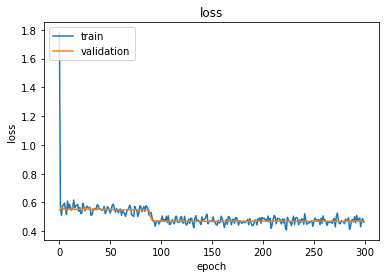

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

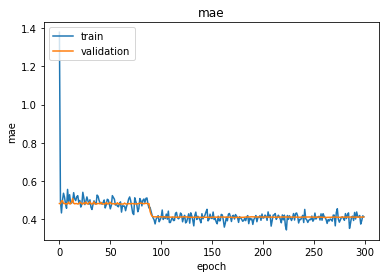

In [15]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Convert Jupyter(.ipynb) to Python(.py) (optional)

In [16]:
# jupyter nbconvert --to script cnn_regression_rmse_image.ipynb